# ID2221 Final Project

In [5]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import os 
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats import chi2


## Setup

In [6]:
spark = SparkSession.builder.master("local[1]").appName("SparkByExamples.com").getOrCreate()
# configuration
os.environ["HADOOP_USER_NAME"] = "hdfs"
os.environ["PYTHON_VERSION"] = "3.8.5"
# localhost of hdfs 
hdfs_path = 'hdfs://127.0.0.1:9000/'

## Data processing

In [4]:
df_weather = spark.read.option("header",True) \
    .csv(hdfs_path + 'data/stockholm_daily_mean_temperature.csv')
df_weather = df_weather.select(col("date"),col("homo").cast("double"))
df_weather = df_weather.withColumnRenamed("homo", "temperature")
df_weather.printSchema()

root
 |-- date: string (nullable = true)
 |-- temperature: double (nullable = true)



In [81]:
df_cases = spark.read.option("header",True) \
    .csv(hdfs_path + 'data/covid-data-per-country.csv')
df_cases = df_cases.filter(col('location') == 'Sweden')
df_cases = df_cases.select(col('date'), 
                            col('new_cases_smoothed').cast("double"), 
                            col('new_deaths_smoothed').cast("double"), 
                            col('new_vaccinations_smoothed').cast("double"))
df_cases = df_cases.na.fill(0.0)
# df_cases.show()
df_cases.printSchema()

root
 |-- date: string (nullable = true)
 |-- new_cases_smoothed: double (nullable = false)
 |-- new_deaths_smoothed: double (nullable = false)
 |-- new_vaccinations_smoothed: double (nullable = false)



In [9]:
# Join weather and covid data on date.
df = df_weather.join(df_cases, on='date', how='inner')
# df.show()

## Analysis

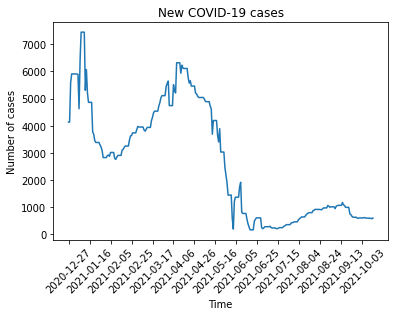

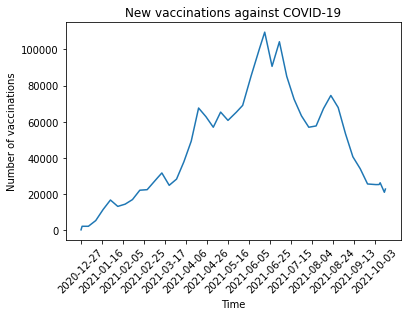

In [63]:
# Cast to pandas for analysis
df_pd = df.toPandas()

# Plot new cases in Sweden
dates = df_pd['date']
plt.plot(dates, df_pd['new_cases_smoothed'])
plt.title('New COVID-19 cases')
plt.ylabel('Number of cases')
plt.xlabel('Time')

l = [dates.iloc[i] for i in range(0, dates.shape[-1], 20)]
ax = plt.gca()
ax.set(xticks=l, xticklabels=l)
plt.xticks(rotation=45)

plt.figure()

# Plot new vaccinations in Sweden.
plt.plot(dates, df_pd['new_vaccinations_smoothed'])
plt.title('New vaccinations against COVID-19')
plt.ylabel('Number of vaccinations')
plt.xlabel('Time')

l = [dates.iloc[i] for i in range(0, dates.shape[-1], 20)]
ax = plt.gca()
ax.set(xticks=l, xticklabels=l)
plt.xticks(rotation=45)

print()

### Running average

In [22]:
from pyspark.sql import Window
window = Window.rowsBetween(-3, 3)
df2 = df.withColumn("avg_vacc", avg("new_vaccinations").over(window))

Text(0.5, 0, 'Number of days')

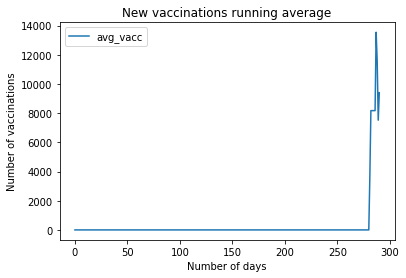

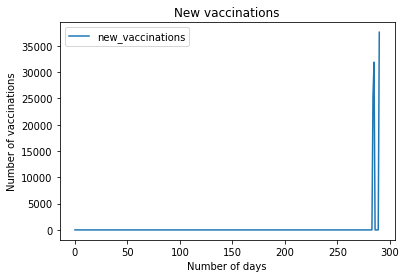

In [68]:
df_pd2 = df2.toPandas()
df_pd2[['avg_vacc']].plot()
plt.title('New vaccinations running average')
plt.ylabel('Number of vaccinations')
plt.xlabel('Number of days')
# df_pd2.columns

df_pd2[["new_vaccinations", 'avg_vacc']]
df_pd2[['new_vaccinations']].plot()
plt.title('New vaccinations')
plt.ylabel('Number of vaccinations')
plt.xlabel('Number of days')


## Correlation

### RandomForest

### New deaths

<ipython-input-80-215897079944>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(df_pd[['new_vaccinations_smoothed', 'temperature', 'rand_num_col']], df_pd[['new_deaths_smoothed']])


Text(0.5, 0, 'Importance')

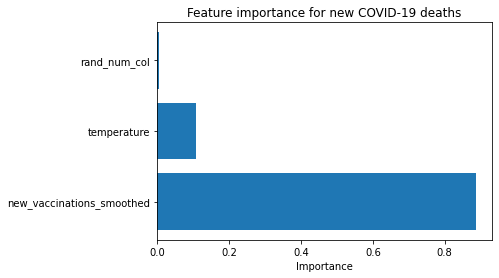

In [80]:
# Add column containing random numbers as a baseline
df_pd['rand_num_col'] = np.random.randint(1, 6, df_pd.shape[0])

model = RandomForestRegressor(n_estimators = 100)
model.fit(df_pd[['new_vaccinations_smoothed', 'temperature', 'rand_num_col']], df_pd[['new_deaths_smoothed']])
importances = model.feature_importances_

plt.barh(['new_vaccinations_smoothed', 'temperature', 'rand_num_col'], model.feature_importances_)
plt.title('Feature importance for new COVID-19 deaths')
plt.xlabel('Importance')

### New cases

<ipython-input-78-6eee62a035a6>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(df_pd[['new_vaccinations_smoothed', 'temperature', 'rand_num_col']], df_pd[['new_cases_smoothed']])


Text(0, 0.5, 'Feature')

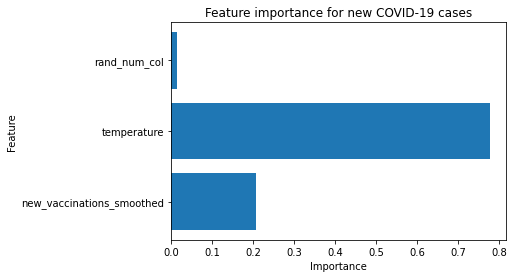

In [78]:
model = RandomForestRegressor(n_estimators = 100)
model.fit(df_pd[['new_vaccinations_smoothed', 'temperature', 'rand_num_col']], df_pd[['new_cases_smoothed']])
importances = model.feature_importances_

plt.barh(['new_vaccinations_smoothed', 'temperature', 'rand_num_col'], model.feature_importances_)
plt.title('Feature importance for new COVID-19 cases')
plt.xlabel('Importance')

### Chi2 test of independence

In [75]:
bins_num = 10
temp_bins = pd.cut(df_pd.temperature, bins_num, labels=[i for i in range(bins_num)])
vacc_bins = pd.cut(df_pd.new_vaccinations_smoothed, bins_num, labels=[i for i in range(bins_num)])
new_cases_bins = pd.cut(df_pd.new_cases_smoothed, bins_num, labels=[i for i in range(bins_num)])
new_deaths_bins = pd.cut(df_pd.new_deaths_smoothed, bins_num, labels=[i for i in range(bins_num)])
rand_bins = pd.cut(df_pd.rand_num_col, bins_num, labels=[i for i in range(bins_num)])

def chi2_test(df1_bins, df2_bins):
	stat, p, dof, expected = chi2_contingency(pd.crosstab(df1_bins, df2_bins))

	# interpret test-statistic
	prob = 0.95
	critical = chi2.ppf(prob, dof)
	if np.abs(stat) >= critical:
		print('Dependent (reject H0)')
	else:
		print('Independent (fail to reject H0)')

print('New cases')
print('Temperature: ', end='') 
chi2_test(temp_bins, new_cases_bins)
print('New vaccinations: ', end='') 
chi2_test(vacc_bins, new_cases_bins)
print('Random: ', end='') 
chi2_test(rand_bins, new_cases_bins)
print('New deaths')
print('Temperature: ', end='') 
chi2_test(temp_bins, new_deaths_bins)
print('New vaccinations: ', end='') 
chi2_test(vacc_bins, new_deaths_bins)
print('Random: ', end='') 
chi2_test(rand_bins, new_deaths_bins)

New cases
Temperature: Dependent (reject H0)
New vaccinations: Dependent (reject H0)
Random: Independent (fail to reject H0)
New deaths
Temperature: Dependent (reject H0)
New vaccinations: Dependent (reject H0)
Random: Independent (fail to reject H0)
